# Exploring precision and recall

## Import module

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Load data

In [2]:
products = pd.read_csv('amazon_baby.csv')

## Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [3]:
products['review'] = products['review'].astype('str')
products['review_clean'] = products['review'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
# Add Sentiment Column
products['sentiment'] = products['rating'].apply(lambda rating: 1 if rating > 3 else -1)

In [4]:
train_idx = pd.read_json("train-idx.json")
test_idx = pd.read_json("test-idx.json")
train_data = products.iloc[train_idx[0].values]
test_data = products.iloc[test_idx[0].values]

# Remove raing of 3 since it is neutral
products = products[products['rating'] != 3]
train_data = train_data[train_data['rating'] != 3]
test_data = test_data[test_data['rating'] != 3]

Quick peek of data:

In [5]:
products.head(5)

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


## Generate word count vector

In [6]:
#------Generate Bag of Words Vector------
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

## Train a logistic regression classifier

We will now train a logistic regression classifier with **sentiment** as the target and **word_count** as the features.

In [7]:
model = LogisticRegression()
model.fit(train_matrix,train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

We compute the **accuracy** of our logistic regression model on the **test_data** as follows:

In [8]:
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.933139534884


## Baseline: Majority class prediction

**The majority classifier** model predicts the majority class for all data points.

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [9]:
# Baseline: Majority class prediction
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8416358350951374


## Confusion Matrix

In [10]:
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3532
     -1       |        1        |  1262
      1       |       -1        |   762
      1       |        1        | 24716


## Precision and Recall

### Precision:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

### Recall:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

In [11]:
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Precision on test data: 0.951420432674
Recall on test data: 0.970091843944


## Precision-recall tradeoff

### Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold.

The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds threshold.

In [12]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    ans = pd.Series([+1 if x >= threshold else -1 for x in probabilities])
    return ans

In [13]:
probabilities = model.predict_proba(test_matrix)[:,1]
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 25978
Number of positive predicted reviews (threshold = 0.9): 22559


### Exploring the associated precision and recall as the threshold varies

In [14]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(y_true=test_data['sentiment'], 
                            y_pred=predictions_with_default_threshold)
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)

recall_with_default_threshold = recall_score(y_true=test_data['sentiment'],
                      y_pred=predictions_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = precision_score(y_true=test_data['sentiment'], 
                            y_pred=predictions_with_high_threshold)
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)

recall_with_high_threshold = recall_score(y_true=test_data['sentiment'],
                      y_pred=predictions_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.5): 0.951420432674
Recall (threshold = 0.5)   : 0.970091843944
Precision (threshold = 0.9): 0.981559466288
Recall (threshold = 0.9)   : 0.869102755318


## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [15]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

For each of the values of threshold, we compute the precision and recall scores.

In [16]:
precision_all = []
recall_all = []
probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=test_data['sentiment'], y_pred = predictions)
    recall = recall_score(y_true=test_data['sentiment'], y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

In [17]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

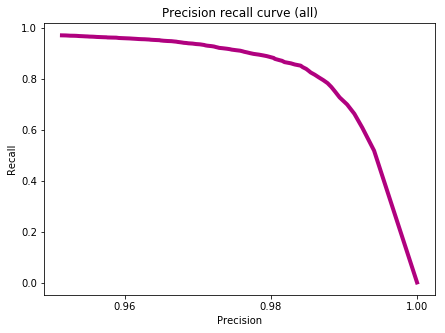

In [18]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

### Precision-Recall on all baby related items

In [19]:
# Evaluating specific search terms
baby_reviews = test_data[test_data['name'].str.lower().str.contains('baby',na=False)]
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])

First, let's consider the following threshold_values ranging from 0.5 to 1:

In [20]:
threshold_values = np.linspace(0.5, 1, num=100)

Second, as we did above, let's compute precision and recall for each value in threshold_values on the baby_reviews dataset. Complete the code block below.

In [21]:
precision_all = []
recall_all = []
probabilities = model.predict_proba(baby_matrix)[:,1]

for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=baby_reviews['sentiment'], y_pred = predictions)
    recall = recall_score(y_true=baby_reviews['sentiment'], y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

Finally, let's plot the precision recall curve.

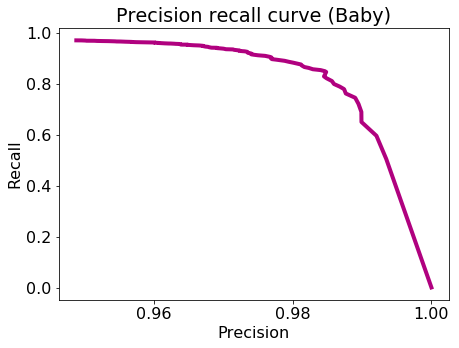

In [22]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (Baby)')